In [1]:
import os
path = os.path.abspath(os.getcwd())
print(path)
folder = os.path.split(path)[-1]
if folder == 'Subjects_Scripts':
    print('Subjects_Scripts')
    %run my_imports.py
elif folder == 'MySpaces':
    print('MySpaces')
    %run Subjects_Scripts/my_imports.py

C:\Users\bastien\Documents\Git\python_analysis_2\project\MySpaces\Subjects_Scripts
Subjects_Scripts


In [2]:
folderSubject = r'D:/DataSet/MySpaces/data/s03/'

In [3]:
folderName = os.path.join(folderSubject,'records','fif','agency')

raws_list,events = load_fif_from_folder(folderName,concatFile=False)

raws = mne.concatenate_raws(raws_list)
events = mne.find_events(raws, stim_channel='TRIGGER', shortest_event = 1)
montageFile = os.path.join(folderAnalysis,'locFile','montageANT64_inverse.txt')
layoutFile  = os.path.join(folderAnalysis,'locFile','antneuro_64ch.lay')
chan_dict_file = os.path.join(folderAnalysis,'locfile','chan_dict_64ANT.txt')

f = open(chan_dict_file,'r')
chan_dict = eval(f.read())
     
cfg= {'spatial_filter': 'CAR',
'montage_file':montageFile,
'layout_file':layoutFile}

scale = dict(mag=1e-12, grad=4e-11, eeg=100, eog=150, ecg=500,
     emg=1e3, ref_meg=1e-12, misc=1e-3, stim=1,
     resp=1e3, chpi=1e-4, whitened=1e2)

print(raws.ch_names)

if 'AUX3' in raws.ch_names:
    print("1")
    resp_channel = "AUX3"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX1':'ecg','AUX3':'resp','M1':'emg','M2':'emg'}
elif 'AUX7' in raws.ch_names:
    print("2")
    resp_channel = "AUX7"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX1':'ecg','AUX7':'resp','M1':'emg','M2':'emg'}
elif 'AUX13' in raws.ch_names:
    print("3")
    resp_channel = "AUX13"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX1':'ecg','AUX13':'resp','M1':'emg','M2':'emg'}


raws.set_channel_types(mapping_channel_type)
raws = set_montage_from_file(raws,cfg,kind='topomap')

print('[Preprocessing] Preprocessed Data')

print('[Events Visualization] Checking events')
print(np.unique(events[:,2]))
print('[Events Visualization] Define dictionary for epoching')

[Load Data] Found 6 files
['TRIGGER', 'FP1', 'FPZ', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'CZ', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'PZ', 'P4', 'P8', 'POZ', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCZ', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'OZ', 'AUX1', 'AUX13']
3
[Preprocessing] Preprocessed Data
[Events Visualization] Checking events
[ 10  20  30  40  60  70  99 110 112 113 114 115 116 117 118 119]
[Events Visualization] Define dictionary for epoching


# Event Preprocessing 

In [4]:
file = os.path.join(folderName,'pilot_logs.csv')
dataFrame = pd.read_csv(file,header=0)
dataFrame.head()

data_type_frame = dataFrame['trial_type']
data_type = data_type_frame.to_numpy()
data_type = (data_type != 'BMI').astype(int)+1
print(np.shape(data_type))

list_Type_trials = dict(cue=2,self=1)
print(list_Type_trials)

(300,)
{'cue': 2, 'self': 1}


In [5]:
idx_data_action = np.where(events[:,2] == 30)[0]
trial_remove = []
trialIdx = []
for i,idx_Start in enumerate(idx_data_action):
    if events[idx_Start + 1,2] == 40:
        pass
    else:
#         print('misssing action - event: ' + str(idx_Start))
#         print('misssing trial: ' + str(i))
        trialIdx.append(i)
        trial_remove.append(idx_Start)
        events[idx_Start-1:idx_Start+2,2] = 1000
        
print(trialIdx,trial_remove)
data_type = np.delete(data_type, trialIdx)
print(np.shape(data_type))

[16, 20, 124, 203, 275, 292] [98, 120, 751, 1227, 1663, 1765]
(294,)


In [6]:
idx_action_event = np.where(events[:,2] == 40)[0]
idx_go_event = np.where(events[:,2] == 30)[0]
idx_start_event = np.where(events[:,2] == 20)[0]
print(len(idx_start_event),len(idx_go_event),len(idx_action_event))

294 294 294


In [7]:
for idx in range(len(idx_action_event)):
    if data_type[idx] == list_Type_trials['cue']:
        events[idx_action_event[idx],2] = 41
        events[idx_go_event[idx],2] = 31
        events[idx_start_event[idx],2] = 21
print('Trials splitted with events')

Trials splitted with events


# EEG Preprocessing

In [8]:
from mne.preprocessing import ICA
method = 'fastica'

# Choose other parameters
n_components = 61  # if float, select n_components by explained variance of PCA
decim = 3  # we need sufficient statistics, not all time points -> saves time

# we will also set state of the random number generator - ICA is a
# non-deterministic algorithm, but we want to have the same decomposition
# and the same order of components each time this tutorial is run
random_state = 23
ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

# Apply Temporal Filtering
picks_eeg = mne.pick_types(raws.info,eeg=True)
raws_filtered = raws.copy()
raws_filtered = raws_filtered.pick(picks_eeg)
raws_filtered.filter(l_freq =1,h_freq = 40)
print('[Preprocessing] Temporal Filtering applied on data (Step 1/3)')

listEventOfInterest = {'MI_START':40}
epochs  = mne.Epochs(raws_filtered, events, event_id=listEventOfInterest,
                         tmin=-8, tmax=6,baseline=None, preload = True)
ica.fit(epochs, picks='eeg', decim=decim)
print(ica)

<ICA  |  no decomposition, fit (fastica):  samples, no dimension reduction>
[Preprocessing] Temporal Filtering applied on data (Step 1/3)
<ICA  |  epochs decomposition, fit (fastica): 224660 samples, 61 components, channels used: "eeg">


In [9]:
# ica.plot_components()  
ica.exclude.extend([0,1])
raws_ICA = ica.apply(raws_filtered)
print('[Preprocessing] Apply ICA on data (Step 2/3)')

[Preprocessing] Apply ICA on data (Step 2/3)


In [10]:
# Apply Spatial Filtering
picks_eeg = mne.pick_types(raws.info,eeg=True)
raws_preprocessed = raws_ICA.copy()
# raws_preprocessed = raws_preprocessed.pick(picks_eeg)
raws_ERDS  = apply_spatial_filter(raws_preprocessed,spatial_filer='CAR')
print('[Preprocessing] Spatial Filtering applied on data (Step 2/3)')

[Preprocessing] Spatial Filtering applied on data (Step 2/3)


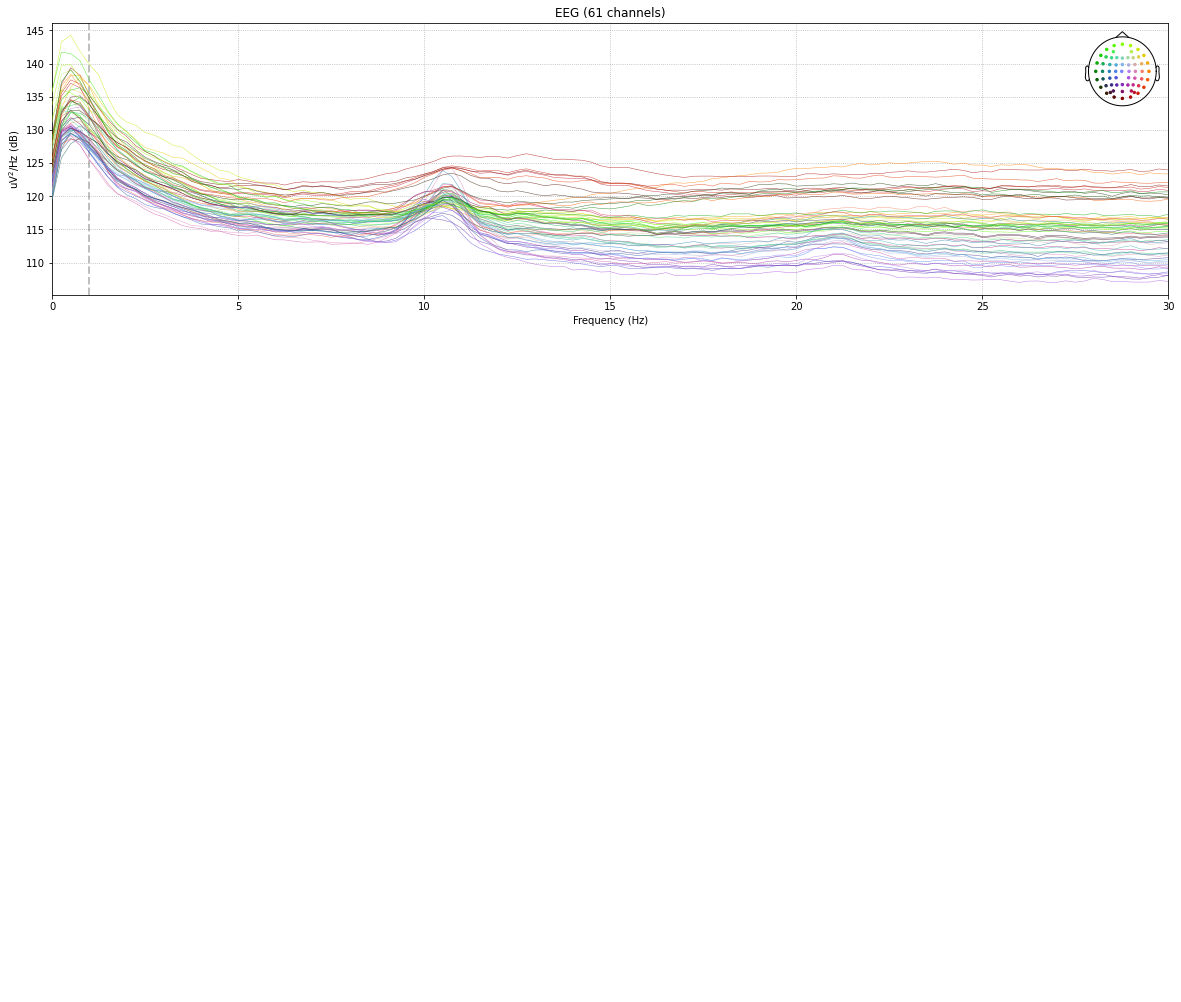

In [11]:
fig = plt.figure(figsize=(20,5))
axs=fig.add_subplot(111)
fig = raws_ERDS.plot_psd(fmin=0,fmax=30,dB =True,ax = axs)

# Compute ERD/S

In [42]:
listEventOfInterest = {'ST_ACTION_SELF':40,'ST_ACTION_CUE':41}

epochs_ERDS = mne.Epochs(raws_ERDS, events, event_id=listEventOfInterest,
                    tmin=-4, tmax=2,baseline=None, preload = True)
baseline = (None,None)
power = []
Power_events = dict()
for i,event_type in enumerate(epochs_ERDS.event_id): 
    print(event_type)
    try:
        power = compute_ERDS(epochs_ERDS[event_type],baseline,mode='logratio')
    except:
        print('Relaunching for whatever reason')
        power = compute_ERDS(epochs_ERDS[event_type],baseline,mode='logratio')
    Power_events.update({event_type:power})

ST_ACTION_SELF
ST_ACTION_CUE


[-3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5]
Mu
ST_ACTION_SELF
ST_ACTION_CUE
Beta
ST_ACTION_SELF
ST_ACTION_CUE


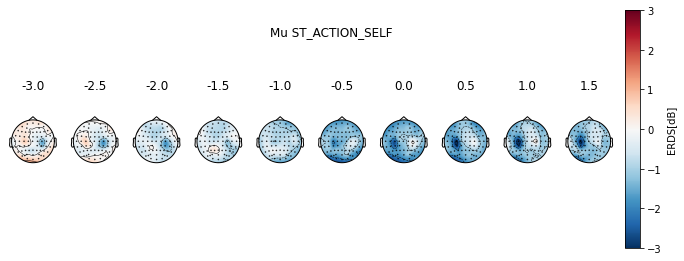

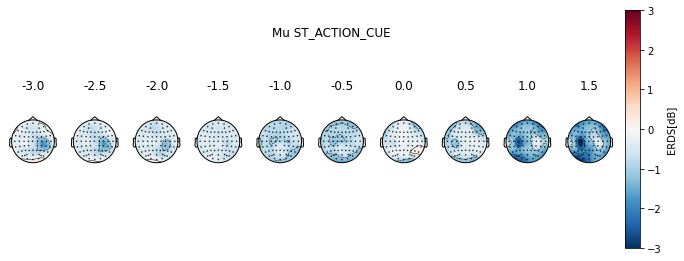

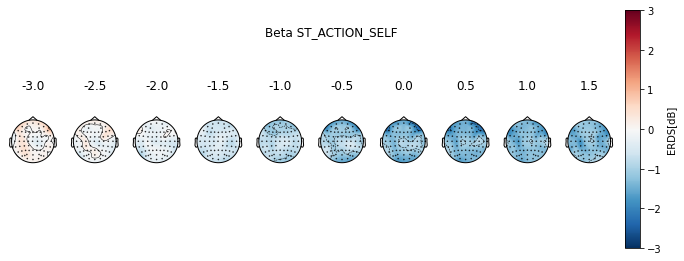

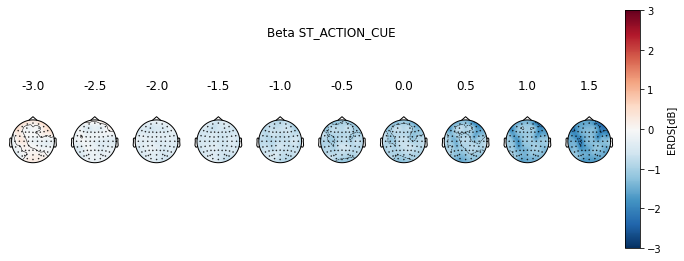

In [37]:
timeOfInterest = np.arange(-3,2,0.5)
print(timeOfInterest)

iter_freqs = [
('Mu', 8, 12),
  ('Beta', 13, 30),
]

my_cmap_r = reverse_colourmap(plt.cm.RdBu, name = 'RdBu')

for band_name,fmin,fmax in iter_freqs:
    print(band_name)
    for iEvent,event_type in enumerate(epochs_ERDS.event_id): 
        print(event_type)
        power = Power_events[event_type]
        fig = plot_topoplot_over_time(power.average(),
                                  timeOfInterest,fmin,fmax,
                                  title=band_name + ' ' + event_type,cmap_use=my_cmap_r,
                                  scale=[-3,3])

In [38]:
channelsOfInterest = ['Fz',\
                      'FCz','FC1','FC2','FC3', 'FC4',\
                     'Cz','C1', 'C2','C3', 'C4',\
                      'CP1', 'CP2','CP3', 'CP4']

# channelsOfInterest = ['FC3','C3','CP3']

print(channelsOfInterest)
channelsOfInterest_idx = mne.pick_channels(raws.ch_names,channelsOfInterest)
print(channelsOfInterest_idx)

['Fz', 'FCz', 'FC1', 'FC2', 'FC3', 'FC4', 'Cz', 'C1', 'C2', 'C3', 'C4', 'CP1', 'CP2', 'CP3', 'CP4']
[10 11 15 17 21 22 41 43 45 46 48 49]


666 -0.3984375
21 -2.91796875
768 0.0
675 -0.36328125


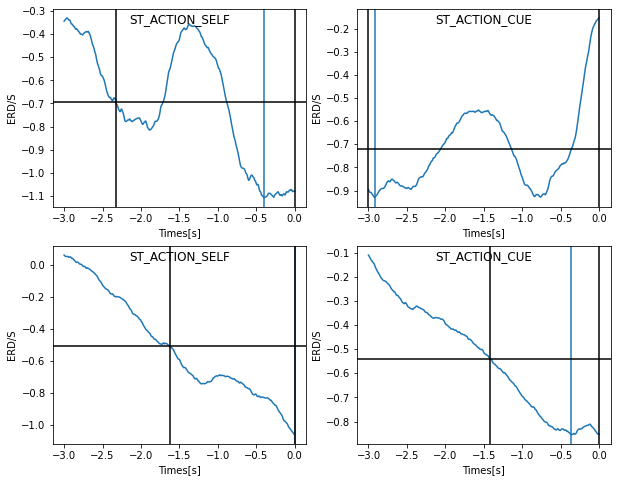

In [39]:
bandOfInterest = [('Mu', 8, 12),('Beta', 13, 30)]

fig,ax = plt.subplots(2,2,figsize=(10,8))
iplot,iband = 0,0


for band_name,fmin,fmax in bandOfInterest:
    iplot = 0
    for iEvent,event_type in enumerate(Power_events.keys()):
        copy_power = Power_events[event_type].copy()
        copy_power =copy_power.crop(fmin=fmin,fmax=fmax,tmin=-3,tmax=0)
        times = copy_power.times
        data_mu = np.mean(copy_power._data[:,channelsOfInterest_idx,:,:],axis=2)
        data_mu = np.mean(np.mean(data_mu,axis=1),axis=0)
        idx_min = np.argmin(data_mu)
        print(idx_min,times[idx_min])
        ax[iband,iplot].axvline(x=times[idx_min])
        ax[iband,iplot].plot(times,data_mu)
        ax[iband,iplot].set_title(event_type,y=0.9)
        ax[iband,iplot].set_xlabel('Times[s]')
        ax[iband,iplot].set_ylabel('ERD/S')
        ax[iband,iplot].axvline(x=0,color='k')
        
        mea = np.mean(data_mu,axis=0)
        idx_baseline_end = np.where(data_mu < mea)[0][0]
        ax[iband,iplot].axhline(y=mea,color='k')
        ax[iband,iplot].axvline(x=times[idx_baseline_end],color='k')
        iplot +=1
    iband+=1

# BandPower Analysis

In [40]:
raws_preprocessed = raws_ERDS.copy()

iter_freqs = [
('Mu', 8, 12),
  ('Beta', 13, 30),
]

epoch_bandpower = dict()

for band_name,fmin,fmax in iter_freqs:
    print(band_name)
    raws_filterband = raws_preprocessed.copy()
   
    # bandpass filter
    raws_filterband.filter(fmin, fmax, n_jobs=1,  # use more jobs to speed up.
                  l_trans_bandwidth=1,  # make sure filter params are the same
                  h_trans_bandwidth=1)  # in each band and skip "auto" option.
    # epoch
    epochs_filterband = mne.Epochs(raws_filterband, events, listEventOfInterest, tmin=-8, tmax=6,preload=True)
    epochs_filterband.apply_hilbert(envelope=True)
    epoch_bandpower.update({band_name:epochs_filterband})
    del epochs_filterband
    del raws_filterband

Mu
Beta


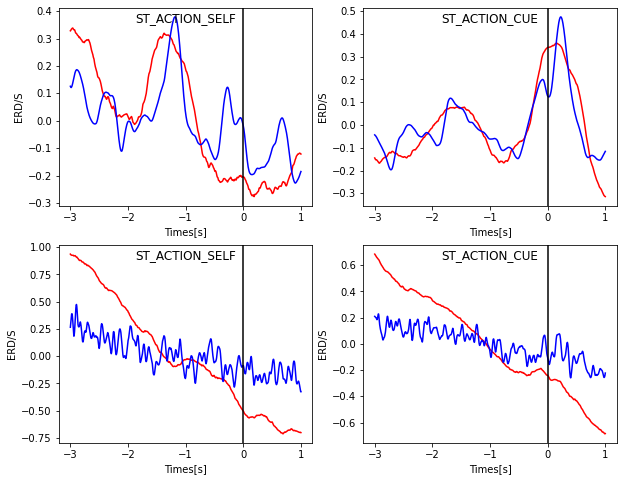

In [41]:
bandOfInterest = [('Mu', 8, 12),('Beta', 13, 30)]
from utils.utils_normalization import zscore_over_trials

fig,ax = plt.subplots(2,2,figsize=(10,8))
iplot,iband = 0,0


for band_name,epochs_band in epoch_bandpower.items():
    iplot = 0
    for iEvent,event_type in enumerate(epochs_band.event_id):
        
        copy_power = Power_events[event_type].copy()
        if band_name == 'Mu':
            fmin,fmax=8,12
        else: 
            fmin,fmax=13,30
            
        copy_power =copy_power.crop(fmin=fmin,fmax=fmax,tmin=-3,tmax=1)
        times = copy_power.times
        data_mu = np.mean(copy_power._data[:,channelsOfInterest_idx,:,:],axis=2)
        data_mu = np.mean(data_mu,axis=1)
        data_mu = zscore_over_trials(data_mu)
        data_mu = np.mean(data_mu,axis=0)
        ax[iband,iplot].plot(times,data_mu,color='r')

    
        copy_power = epochs_band[event_type].copy()
        copy_power =copy_power.crop(tmin=-3,tmax=1)
        times = copy_power.times
        data_mu = np.mean(copy_power._data[:,channelsOfInterest_idx,:],axis=1)
        data_mu = zscore_over_trials(data_mu)
        data_mu = np.mean(data_mu,axis=0)

        ax[iband,iplot].plot(times,data_mu,color='b')
        ax[iband,iplot].set_title(event_type,y=0.9)
        ax[iband,iplot].set_xlabel('Times[s]')
        ax[iband,iplot].set_ylabel('ERD/S')
        ax[iband,iplot].axvline(x=0,color='k')
        iplot +=1
    iband+=1

# Saving Data


In [16]:
saving_var('epochs_ERDS',folderSubject,epochs_ERDS)
saving_var('power_events',folderSubject,Power_events)